In [2]:
import os
import sys
import gzip
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set plot style
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# 从训练脚本导入必要的函数和类
# 定义配置和必要的函数
@dataclass
class Config:
    outdir: str
    tsv: str
    seq_len: int = 4096
    batch_size: int = 64
    num_workers: int = 4
    cache_dir: str = ""
    max_cache_bp: int = 200_000

VOCAB = {"A": 1, "C": 2, "G": 3, "T": 4, "N": 5}  # 0 PAD

def read_first_fasta_sequence_gz(path: str) -> str:
    seq_lines = []
    with gzip.open(path, "rt") as f:
        for line in f:
            if line.startswith(">"):
                if seq_lines:
                    break
                continue
            seq_lines.append(line.strip())
    return "".join(seq_lines).upper()

def encode_full_seq_to_uint8(seq: str) -> np.ndarray:
    arr = np.zeros(len(seq), dtype=np.uint8)
    for i, ch in enumerate(seq):
        arr[i] = VOCAB.get(ch, 5)
    return arr

def build_genome_path(outdir: str, taxid: str, asm: str, db_source: str) -> str:
    base = "refseq" if db_source == "refseq" else "genbank"
    return os.path.join(outdir, base, "downloads", taxid, asm, f"{asm}_genomic.fna.gz")


In [3]:
# 数据集类（简化版，用于加载和可视化）
class ViralFamilyFullSeqDataset:
    def __init__(self, df: pd.DataFrame, cfg: Config, label2id: dict):
        self.df = df.reset_index(drop=True)
        self.cfg = cfg
        self.label2id = label2id
        self.cache_dir = cfg.cache_dir
        if self.cache_dir:
            os.makedirs(self.cache_dir, exist_ok=True)

    def __len__(self):
        return len(self.df)

    def _cache_path(self, asm: str) -> str:
        return os.path.join(self.cache_dir, f"{asm}.npy")

    def __getitem__(self, idx: int):
        r = self.df.iloc[idx]
        taxid = str(r["taxid"])
        asm = str(r["asm"])
        db = str(r["db_source"])
        y = self.label2id[str(r["family"])]

        # 1) load from cache if exists
        if self.cache_dir:
            cp = self._cache_path(asm)
            if os.path.exists(cp):
                x_full = np.load(cp, mmap_mode=None)  # uint8
                return x_full, int(y)

        # 2) load fasta.gz and encode full
        fna = build_genome_path(self.cfg.outdir, taxid, asm, db)
        if not os.path.exists(fna):
            x_full = np.zeros(0, dtype=np.uint8)
        else:
            seq = read_first_fasta_sequence_gz(fna)
            x_full = encode_full_seq_to_uint8(seq)

        # 3) optionally cache
        if self.cache_dir:
            if self.cfg.max_cache_bp <= 0 or len(x_full) <= self.cfg.max_cache_bp:
                np.save(self._cache_path(asm), x_full)

        return x_full, int(y)


In [ ]:
# 配置路径（根据实际情况修改）
# 如果环境变量已设置，使用环境变量；否则使用默认路径
OUTDIR = os.environ.get("OUTDIR", "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/ncbi_viral")
TSV = os.environ.get("TSV", os.path.join(OUTDIR, "merged", "rep.family_top100.tsv"))

# 检查是否存在已生成的 split 文件
split_dir = os.path.join(OUTDIR, "merged", "splits_genus_disjoint")
use_existing_splits = os.path.exists(os.path.join(split_dir, "train.tsv"))

print(f"OUTDIR: {OUTDIR}")
print(f"TSV: {TSV}")
print(f"使用已存在的 split 文件: {use_existing_splits}")

OUTDIR: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/ncbi_viral
TSV: /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/ncbi_viral/merged/rep.family_top100.tsv
使用已存在的 split 文件: True


In [14]:
# 加载数据
if use_existing_splits:
    # 使用已存在的 split 文件
    train_df = pd.read_csv(os.path.join(split_dir, "train.tsv"), sep="\t")
    val_df = pd.read_csv(os.path.join(split_dir, "val.tsv"), sep="\t")
    test_df = pd.read_csv(os.path.join(split_dir, "test.tsv"), sep="\t")
    print(f"从 split 文件加载: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")
else:
    # 从原始 TSV 加载（需要重新 split）
    from sklearn.model_selection import GroupShuffleSplit
    
    def make_group_key(df: pd.DataFrame) -> pd.Series:
        g = df["genus"].astype(str).fillna("")
        bad = g.isna() | (g.str.strip() == "") | (g.str.upper() == "NA") | (g.str.upper() == "NAN") | (g == "-")
        key = g.copy()
        key[bad] = "taxid_" + df.loc[bad, "taxid"].astype(str)
        return key
    
    def group_split_2way(df: pd.DataFrame, groups: pd.Series, test_size: float, seed: int):
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
        idx_a, idx_b = next(gss.split(df, groups=groups))
        return df.iloc[idx_a].copy(), df.iloc[idx_b].copy()
    
    df = pd.read_csv(TSV, sep="\t")
    df["group_key"] = make_group_key(df)
    
    train_all, test_df = group_split_2way(df, df["group_key"], test_size=0.10, seed=42)
    train_df, val_df = group_split_2way(train_all, train_all["group_key"], test_size=0.10, seed=43)
    
    # 确保类别在训练集中存在
    fam_train = set(train_df["family"].astype(str).unique())
    train_df = train_df[train_df["family"].astype(str).isin(fam_train)].copy()
    val_df = val_df[val_df["family"].astype(str).isin(fam_train)].copy()
    test_df = test_df[test_df["family"].astype(str).isin(fam_train)].copy()
    
    print(f"重新 split: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

# 创建 label2id 映射
families = sorted(train_df["family"].astype(str).unique())
label2id = {f: i for i, f in enumerate(families)}
id2label = {i: f for f, i in label2id.items()}

print(f"\n数据集统计:")
print(f"  训练集: {len(train_df)} 样本")
print(f"  验证集: {len(val_df)} 样本")
print(f"  测试集: {len(test_df)} 样本")
print(f"  类别数: {len(families)}")


从 split 文件加载: train=13261, val=2348, test=1933

数据集统计:
  训练集: 13261 样本
  验证集: 2348 样本
  测试集: 1933 样本
  类别数: 100


Total dataset size: 17542 samples

Loading sequence lengths for all 17542 samples...


Loading sequences: 100%|██████████| 17542/17542 [00:25<00:00, 678.34it/s] 



Sequence Length Statistics (based on 17542 samples):
  Min length: 165 bp
  Max length: 1,991,922 bp
  Mean length: 39,876 bp
  Median length: 9,206 bp
  Std deviation: 73,247 bp


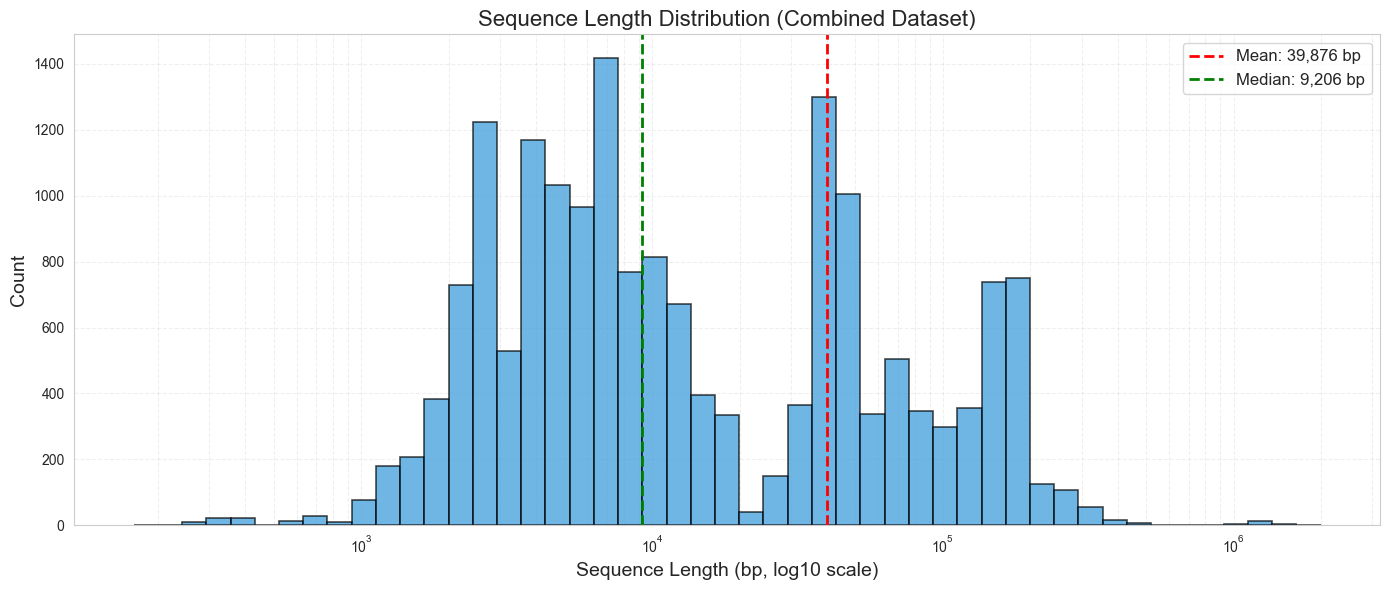

In [18]:
# Visualization: Sequence Length Distribution (Combined Dataset)
# Merge train, val, and test datasets
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(f"Total dataset size: {len(all_df)} samples")

# Configure paths
cfg = Config(
    outdir=OUTDIR,
    tsv=TSV,
    cache_dir=os.path.join(OUTDIR, "merged", "cache_fullseq_uint8_top100")
)

# Create dataset for all samples
all_ds = ViralFamilyFullSeqDataset(all_df, cfg, label2id)

# Load all sequence lengths
print(f"\nLoading sequence lengths for all {len(all_ds)} samples...")
seq_lengths = []
for idx in tqdm(range(len(all_ds)), desc="Loading sequences"):
    try:
        x_full, y = all_ds[idx]
        seq_lengths.append(len(x_full))
    except Exception as e:
        print(f"Warning: Failed to load index {idx}: {e}")
        continue

seq_lengths = np.array(seq_lengths)
print(f"\nSequence Length Statistics (based on {len(seq_lengths)} samples):")
print(f"  Min length: {seq_lengths.min():,} bp")
print(f"  Max length: {seq_lengths.max():,} bp")
print(f"  Mean length: {seq_lengths.mean():,.0f} bp")
print(f"  Median length: {np.median(seq_lengths):,.0f} bp")
print(f"  Std deviation: {seq_lengths.std():,.0f} bp")

# Plot histogram: x-axis = length (log10 scale), y-axis = count
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Use log-spaced bins for better visualization with log scale
log_min = np.log10(seq_lengths[seq_lengths > 0].min())
log_max = np.log10(seq_lengths.max())
log_bins = np.logspace(log_min, log_max, 50)

ax.hist(seq_lengths, bins=log_bins, color='#3498db', alpha=0.7, edgecolor='black', linewidth=1.2)
ax.set_xscale('log')  # Set x-axis to log10 scale
ax.set_xlabel('Sequence Length (bp, log10 scale)', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Sequence Length Distribution (Combined Dataset)', fontsize=16)
ax.grid(alpha=0.3, linestyle='--', which='both')  # Show grid for both major and minor ticks

# Add mean and median lines
mean_val = seq_lengths.mean()
median_val = np.median(seq_lengths)
ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:,.0f} bp')
ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:,.0f} bp')
ax.legend(fontsize=12)

# # Add text box with statistics
# textstr = f'Total samples: {len(seq_lengths):,}\nMin: {seq_lengths.min():,} bp\nMax: {seq_lengths.max():,} bp'
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# ax.text(0.98, 0.98, textstr, transform=ax.transAxes, fontsize=11,
#         verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

In [19]:
# 读取文件
tsv_file_path = "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/ncbi_viral/merged/rep.family_top100.with_header.with_host.with_group.corrected.cleaned_host.tsv"

# 使用 pandas 读取 TSV 文件
df = pd.read_csv(tsv_file_path, sep="\t")

# 过滤数据：排除 host_group 为 "UNK" 或 "OTHER" 的行
df_filtered = df[(df['host_group_changed'] != "UNK") & (df['host_group_changed'] != "OTHER")]

# 或者使用更简洁的方式：
# df_filtered = df[~df['host_group'].isin(["UNK", "OTHER"])]

print(f"原始数据: {len(df)} 行")
print(f"过滤后数据: {len(df_filtered)} 行")
print(f"\nhost_group 值分布:")
print(df['host_group'].value_counts())

原始数据: 5789 行
过滤后数据: 5789 行

host_group 值分布:
host_group
A     2971
D3     589
E      547
B      543
C      450
D1     368
D2     321
Name: count, dtype: int64


In [24]:
# 统计每个 host_group 包含多少个不同的 host_name
host_group_host_count = df_filtered.groupby('host_group_fixed')['host_name_clean'].nunique().sort_values(ascending=False)

# 准备输出文件路径
output_dir = os.path.dirname(tsv_file_path)
txt_output_path = os.path.join(output_dir, "host_group_host_name_statistics.txt")

# 使用 StringIO 收集所有输出内容
from io import StringIO
output_buffer = StringIO()

# 定义一个函数，同时输出到控制台和缓冲区
def print_both(*args, **kwargs):
    print(*args, **kwargs)  # 输出到控制台
    print(*args, file=output_buffer, **kwargs)  # 输出到缓冲区

print_both("每个 host_group 包含的不同 host_name 数量:")
print_both("=" * 50)
# 将 pandas Series 转换为字符串以便写入文件
host_count_str = str(host_group_host_count)
print(host_count_str)  # 控制台输出
output_buffer.write(host_count_str + "\n")  # 文件输出
print_both("\n" + "=" * 50)
print_both(f"总计: {len(df_filtered)} 行数据")
print_both(f"不同的 host_group 数量: {len(host_group_host_count)}")
print_both(f"不同的 host_name 总数: {df_filtered['host_name_clean'].nunique()}")

# 更详细的统计：显示每个 host_group 的具体 host_name 列表
print_both("\n" + "=" * 50)
print_both("每个 host_group 的 host_name 详情:")
print_both("=" * 50)
for host_group in host_group_host_count.index:
    # 获取当前 host_group 的数据
    group_df = df_filtered[df_filtered['host_group_fixed'] == host_group]
    host_names = group_df['host_name_clean'].unique()
    # 过滤掉空值
    host_names = [h for h in host_names if pd.notna(h) and str(h).strip() != '']
    sorted_host_names = sorted(host_names)
    
    # 统计每个 host_name 在当前 host_group 中的出现次数
    host_name_counts_in_group = group_df[group_df['host_name_clean'].notna() & (group_df['host_name_clean'].str.strip() != '')]['host_name_clean'].value_counts()
    
    # 计算该 host_group 的总行数
    group_total_count = len(group_df)
    
    # 控制台输出：如果太多则省略
    print(f"\n{host_group} ({len(host_names)} 个不同的 host_name):")
    if len(host_names) <= 20:
        for i, hn in enumerate(sorted_host_names, 1):
            count = host_name_counts_in_group.get(hn, 0)
            print(f"  {i}. {hn} ({count} 次)")
    else:
        # 如果太多，只显示前10个和后10个
        for i, hn in enumerate(sorted_host_names[:10], 1):
            count = host_name_counts_in_group.get(hn, 0)
            print(f"  {i}. {hn} ({count} 次)")
        print(f"  ... (还有 {len(host_names) - 20} 个)")
        for i, hn in enumerate(sorted_host_names[-10:], len(host_names) - 9):
            count = host_name_counts_in_group.get(hn, 0)
            print(f"  {i}. {hn} ({count} 次)")
    print(f"  总计: {group_total_count} 行")
    
    # 文件输出：显示完整的列表，不省略，包含出现次数
    output_buffer.write(f"\n{host_group} ({len(host_names)} 个不同的 host_name):\n")
    for i, hn in enumerate(sorted_host_names, 1):
        count = host_name_counts_in_group.get(hn, 0)
        output_buffer.write(f"  {i}. {hn} ({count} 次)\n")
    output_buffer.write(f"  总计: {group_total_count} 行\n")

# 统计每个 host_name 的出现次数
print_both("\n\n" + "=" * 50)
print_both("每个 host_name 的出现次数统计:")
print_both("=" * 50)

# 统计每个 host_name_clean 的出现次数（排除空值）
host_name_counts = df_filtered[df_filtered['host_name_clean'].notna() & (df_filtered['host_name_clean'].str.strip() != '')]['host_name_clean'].value_counts().sort_values(ascending=False)

host_count_str = str(host_name_counts)
print(host_count_str)  # 控制台输出
output_buffer.write("\n\n" + "=" * 50 + "\n")
output_buffer.write("每个 host_name 的出现次数统计:\n")
output_buffer.write("=" * 50 + "\n")
output_buffer.write(host_count_str + "\n")

print_both(f"\n总计: {len(df_filtered)} 行数据")
print_both(f"不同的 host_name 总数: {len(host_name_counts)}")
print_both(f"host_name 出现次数总和: {host_name_counts.sum()}")

# 显示每个 host_name 的详细统计（写入文件，控制台显示前20个）
print_both("\n" + "=" * 50)
print_both("每个 host_name 的详细统计:")
print_both("=" * 50)

# 控制台输出：只显示前20个
print("\n前20个出现次数最多的 host_name:")
for i, (host_name, count) in enumerate(host_name_counts.head(20).items(), 1):
    print(f"  {i}. {host_name}: {count} 次")

# 文件输出：显示完整的统计
output_buffer.write("\n" + "=" * 50 + "\n")
output_buffer.write("每个 host_name 的详细统计:\n")
output_buffer.write("=" * 50 + "\n")
for i, (host_name, count) in enumerate(host_name_counts.items(), 1):
    output_buffer.write(f"  {i}. {host_name}: {count} 次\n")

# 将缓冲区内容写入文件
with open(txt_output_path, 'w', encoding='utf-8') as f:
    f.write(output_buffer.getvalue())

print_both(f"\n\n统计结果已保存到文件:")
print_both(f"  {txt_output_path}")

每个 host_group 包含的不同 host_name 数量:
host_group_fixed
E     143
D3     99
C      74
A      33
B      32
D2     32
D1      7
Name: host_name_clean, dtype: int64

总计: 5789 行数据
不同的 host_group 数量: 7
不同的 host_name 总数: 419

每个 host_group 的 host_name 详情:

E (143 个不同的 host_name):
  1. Aedes aegypti (3 次)
  2. Aedes albopictus (10 次)
  3. Aedes campestris (1 次)
  4. Aedes cumminsii (1 次)
  5. Aedes curtipes (1 次)
  6. Aedes dorsalis (1 次)
  7. Aedes fulvus (1 次)
  8. Aedes japonicus (1 次)
  9. Aedes normanensis (1 次)
  10. Aedes opok (1 次)
  ... (还有 123 个)
  134. blue swimmer crab (1 次)
  135. fiddler crab (1 次)
  136. freshwater atyid shrimp (1 次)
  137. hard ticks (1 次)
  138. hermit Crab (1 次)
  139. hermit crab (2 次)
  140. insect (5 次)
  141. oyster mushroom (1 次)
  142. sand fly (2 次)
  143. sandfly (6 次)
  总计: 547 行

D3 (99 个不同的 host_name):
  1. Amblyomma variegatum/Hipposideros jonesi (1 次)
  2. Aselliscus stoliczkanus (1 次)
  3. Bat (Chiroptera) (25 次)
  4. Cardioderma cor (1 次)
  5. Cerv

In [21]:
# 保存过滤后的数据为 TSV 文件（添加 clean 后缀）
# 获取原文件路径和目录
output_dir = os.path.dirname(tsv_file_path)
original_filename = os.path.basename(tsv_file_path)
# 在文件名中添加 .clean 后缀（在 .tsv 之前）
if original_filename.endswith('.tsv'):
    clean_filename = original_filename.replace('.tsv', '.clean.tsv')
else:
    clean_filename = original_filename + '.clean.tsv'

output_path = os.path.join(output_dir, clean_filename)

# 保存为 TSV 文件
df_filtered.to_csv(output_path, sep='\t', index=False)

print(f"已保存过滤后的数据到:")
print(f"  {output_path}")
print(f"  数据行数: {len(df_filtered)}")
print(f"  数据列数: {len(df_filtered.columns)}")
print(f"\n列名: {', '.join(df_filtered.columns.tolist())}")


已保存过滤后的数据到:
  /inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/ncbi_viral/merged/rep.family_top100.with_header.with_host.with_group.corrected.cleaned_host.clean.tsv
  数据行数: 5789
  数据列数: 28

列名: taxid, ftp_path, asm, organism_name, source, family, genus, species, db_source, extra_0, extra_1, extra_2, extra_3, extra_4, extra_5, extra_6, host_name, host_name_raw, lab_host_name, isolation_source, gbff_path, host_group, host_group_raw, expected_group, expected2, host_group_fixed, host_group_changed, host_name_clean


Train: 13261 samples, length range: 165 - 1,991,922 bp
Val: 2348 samples, length range: 229 - 351,909 bp
Test: 1933 samples, length range: 292 - 1,573,504 bp

合并数据集统计:
  总样本数: 17,542
  平均长度: 39,876 bp
  中位数长度: 9,206 bp


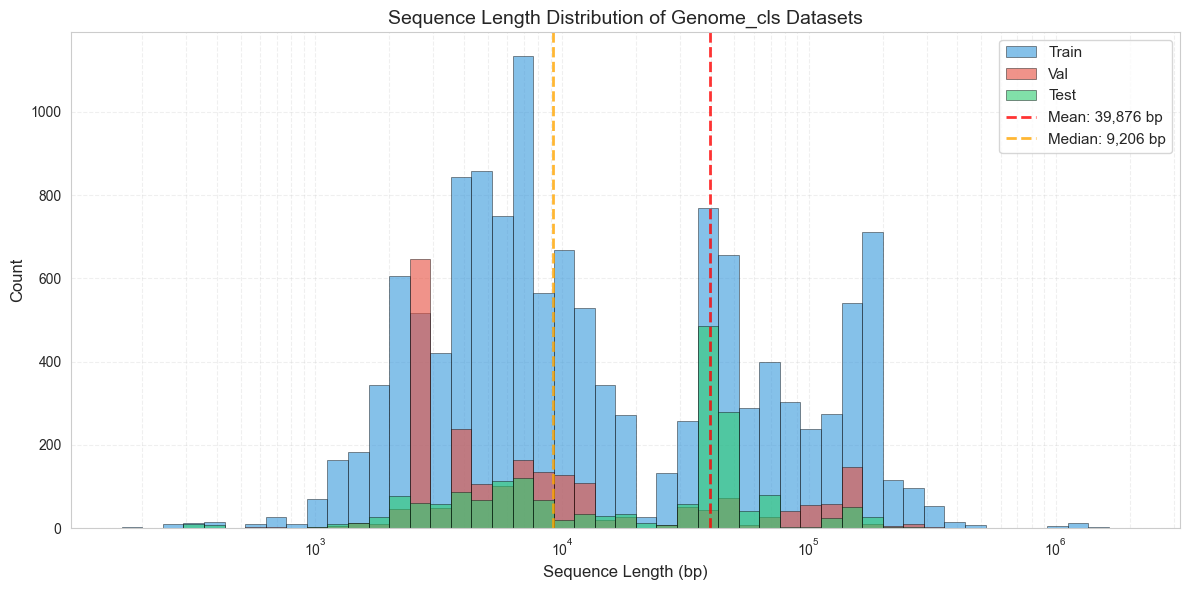

In [5]:
# 可视化 Genome_cls 三个数据集的长度分布
import os

# 读取三个数据集
data_dir = "/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/genome_cls"
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
val_df = pd.read_csv(os.path.join(data_dir, "val.csv"))
test_df = pd.read_csv(os.path.join(data_dir, "test.csv"))

# 计算每个数据集的序列长度
train_lengths = train_df['sequence'].str.len().values
val_lengths = val_df['sequence'].str.len().values
test_lengths = test_df['sequence'].str.len().values

print(f"Train: {len(train_lengths)} samples, length range: {train_lengths.min():,} - {train_lengths.max():,} bp")
print(f"Val: {len(val_lengths)} samples, length range: {val_lengths.min():,} - {val_lengths.max():,} bp")
print(f"Test: {len(test_lengths)} samples, length range: {test_lengths.min():,} - {test_lengths.max():,} bp")

# 绘制长度分布图
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# 使用直方图，设置 density=True 显示频率
bins = np.logspace(np.log10(min(train_lengths.min(), val_lengths.min(), test_lengths.min())), 
                   np.log10(max(train_lengths.max(), val_lengths.max(), test_lengths.max())), 
                   50)

ax.hist(train_lengths, bins=bins, alpha=0.6, label='Train', color='#3498db', density=False, 
        edgecolor='black', linewidth=0.5, weights=None)
ax.hist(val_lengths, bins=bins, alpha=0.6, label='Val', color='#e74c3c', density=False, 
        edgecolor='black', linewidth=0.5, weights=None)
ax.hist(test_lengths, bins=bins, alpha=0.6, label='Test', color='#2ecc71', density=False, 
        edgecolor='black', linewidth=0.5, weights=None)

# 合并三个数据集的长度，计算平均长度和中位数
all_lengths = np.concatenate([train_lengths, val_lengths, test_lengths])
mean_length = np.mean(all_lengths)
median_length = np.median(all_lengths)

print(f"\n合并数据集统计:")
print(f"  总样本数: {len(all_lengths):,}")
print(f"  平均长度: {mean_length:,.0f} bp")
print(f"  中位数长度: {median_length:,.0f} bp")

ax.set_xscale('log')
ax.set_xlabel('Sequence Length (bp)', fontsize=12, weight='normal')
ax.set_ylabel('Count', fontsize=12, weight='normal')
ax.set_title('Sequence Length Distribution of Genome_cls Datasets', fontsize=14, weight='normal')
ax.legend(fontsize=11, frameon=True, fancybox=True, shadow=False)
ax.grid(True, alpha=0.3, linestyle='--', which='both')

# 添加平均长度和中位数线
ax.axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_length:,.0f} bp', alpha=0.8)
ax.axvline(median_length, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_length:,.0f} bp', alpha=0.8)

# 更新图例以包含平均长度和中位数线
ax.legend(fontsize=11, frameon=True, fancybox=True, shadow=False)

# 设置所有文本元素不加粗
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_weight('normal')

plt.tight_layout()
plt.show()

请你帮我可视化一下/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/data/C2_data.csv数据集的长度分布
数据集的示例如下
idx,taxid,organism_name,family,genus,species,host_name,host_group
0,10566,Human papillomavirus,Papillomaviridae,nan,Human papillomavirus,Homo sapiens,D1
1,10571,Bovine papillomavirus,Papillomaviridae,nan,Bovine papillomavirus,Bos taurus,D2
其中 host_group 为分组，有A、B、C、D1、D2、D3、E
请你帮我绘制CDS长度的平均值，其中横坐标为A、B、C、D1、D2、D3、E
纵坐标为CDS的长度，CDS来自文件/inspire/hdd/project/aiscientist/yedongxin-CZXS25120006/DNAFM/GeneShield/data/data/C2_data_cds.json
每行有多个CDS